In [31]:
# Bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [32]:
#Parâmetros físicos e dados do ímã

U0 = 4*np.pi*1e-7
g0 = 1e-3
W  = 4e-2
D  = 3.5e-2
d  = 8e-3
A  = W * D

num_pontos = 200

B = np.array([0, 0.2, 0.6,  0.7,  0.75, 0.8,  0.85, 0.96, 1.02, 1.05, 1.08, 1.11, 1.13, 1.15, 1.18, 1.2])

H = np.array([-50200, -49500, -48000, -47000, -46000, -45000, -44000, -40000, -35000,-30000, -25000, -20000, -15000, -10000, -5000, 0])

# Interpolação completa (curva real): H = f(B)
f_real = CubicSpline(B, H, bc_type="natural")

# "Dados lineares" (como no exemplo): dois pontos extremos
B_linear = np.array([0.0, 1.2])
H_linear = np.array([-50200.0, 0.0])

# Interpolação linear: H = f(B) (com 2 pontos vira uma reta)
f_linear = CubicSpline(B_linear, H_linear, bc_type="natural")

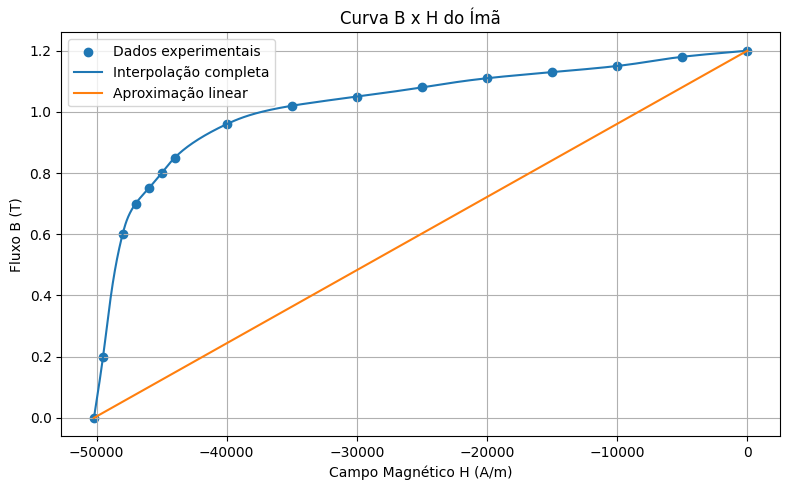

In [33]:
# BLOCO 3 — Plot da curva B×H 

# Vetor suave de B para desenhar as curvas
B_a = np.linspace(np.min(B), np.max(B), num_pontos)

# Avalia as curvas em B_a
H_a_real = f_real(B_a)
H_a_linear = f_linear(B_a)

plt.figure(figsize=(8, 5))

# Pontos experimentais (do fabricante)
plt.scatter(H, B, label="Dados experimentais")

# Interpolação completa (curva real)
plt.plot(H_a_real, B_a, label="Interpolação completa")

# Aproximação linear
plt.plot(H_a_linear, B_a, label="Aproximação linear")

plt.xlabel("Campo Magnético H (A/m)")
plt.ylabel("Fluxo B (T)")
plt.title("Curva B x H do Ímã")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

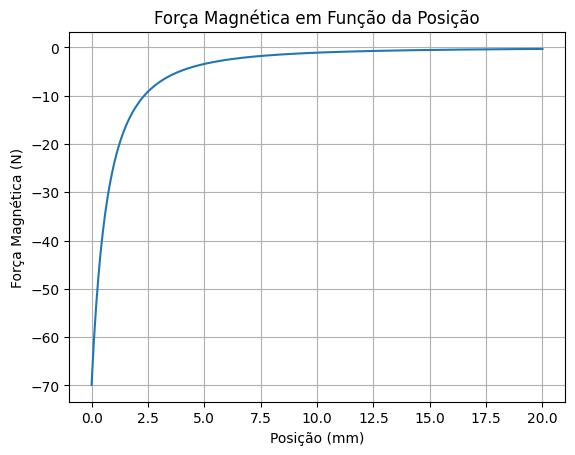

In [34]:
# Vetor de posições (0 a 20 mm em metros)
x = np.linspace(0, 0.02, num_pontos)

# Entreferro variável
g = g0 + x

# Denominador da expressão de Hm
termo = m + (U0 * d/g)

# Campo magnético no ímã
Hm = -Br / termo

# Densidade de fluxo magnético no entreferro (igual ao do ímã)
B = m*Hm + Br

# Força magnética no entreferro
F = -((B**2)*A) / (2*U0)

# Conversão da posição para milímetros (apenas para o gráfico)
x_mm = 1000 * x

# Gráfico da força magnética em função da posição
plt.plot(x_mm, F)
plt.xlabel("Posição (mm)")
plt.ylabel("Força Magnética (N)")
plt.title("Força Magnética em Função da Posição")
plt.grid(True)
plt.show() 